<a href="https://colab.research.google.com/github/Mugambi645/ml-and-dl-notebooks/blob/main/predicting_houseprices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Predicting house prices: A regression example</h2>

## California Housing Price Dataset — Summary

The dataset is based on the 1990 California census and aims to **predict the median house price** in various California districts.

### Dataset Overview
Each data point represents a **block group** (similar to a small district).  
There are two versions of the dataset:
- **Small version:** ~600 districts  
- **Large version:** 20,640 districts  

The small version is often used to demonstrate how to work with limited real-world data.

### Features (8 total)
For each district, the dataset provides:

1. **Longitude** – geographic coordinate  
2. **Latitude** – geographic coordinate  
3. **Median house age**  
4. **Population** (average ≈ 1,425 people)  
5. **Number of households**  
6. **Median household income**  
7. **Total number of rooms** (sum across all homes in the district)  
8. **Total number of bedrooms**

### Objective
Use these eight variables to **predict the median house value** for each district.


In [2]:
from keras.datasets import california_housing

(train_data, train_targets), (test_data, test_targets) = (california_housing.load_data(version="small"))

train_data.shape

743530/743530 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(480, 8)

In [3]:
test_data.shape

(120, 8)

We have **480 training samples** and **120 test samples**, each with **8 numerical features**, and the target is the **median home value (in dollars)** for each district.


In [4]:
train_targets

array([228400., 132900.,  60000.,  95200., 107000., 122500., 132000.,
       290100., 257800., 390100., 220800., 284900.,  97500., 415300.,
        84200., 185600., 216700., 233100., 127000., 182300.,  92300.,
        90700., 102100., 112500., 350700., 156500., 220700., 147400.,
       216700., 275000., 198200., 119100., 289500., 152500., 125000.,
       104500.,  93800.,  89300., 452600., 128600., 311500.,  90000.,
       218200., 131300.,  67500., 139400., 500001., 182600., 111300.,
       112500., 134700.,  71300., 207400., 331400., 107900.,  87500.,
       342200.,  87100., 314700., 368600., 211600., 338900., 366100.,
       164300.,  91700., 261400., 218500., 155400., 273700.,  81800.,
       138800.,  99700., 156300., 140600., 152700., 108900., 351200.,
       126000., 137500., 196900., 240000., 172800., 254200.,  97500.,
       182700., 162500.,  86100., 226700., 412500., 165900., 327100.,
       162500., 188800., 183800.,  90600., 372000., 275000., 151800.,
       125000., 1291


The prices are between $60,000 and $500,000. If that sounds cheap, remember that this was in 1990, and these prices aren’t adjusted for inflation.

### Preparing the Data — Summary

Neural networks struggle when input features have very different value ranges.  
To make training easier and more stable, it's standard practice to apply **feature-wise normalization**:

- For each feature (each column):
  - Subtract the feature’s **mean**  
  - Divide by its **standard deviation**

This centers each feature around **0** with a **unit standard deviation**, ensuring all inputs have comparable scales. This preprocessing can be done easily with NumPy.


In [6]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

### Normalizing Test Data and Scaling Targets — Summary

- **Normalize test data using statistics from the training data only.**  
  Never compute normalization values (mean, std) from the test set, as this would leak information and invalidate the evaluation.

- **Scale the target values as well.**  
  Since inputs are normalized and the model’s initial predictions are small, large target values (e.g., \$60k–\$500k) would require very large weights and slow down learning.

- **Solution:** divide all targets by **100,000**.  
  This reduces target values to a range of about **0.6 to 5**, allowing the model to learn faster.

- After training, multiply predictions by **100,000** to return to dollar values.


In [7]:
y_train = train_targets / 100000
y_test = test_targets / 100000


### Building the Model — Summary

Because the dataset has very **few samples**, a **small neural network** is used to reduce the risk of overfitting.  
The model consists of:

- **Two hidden layers**, each with **64 units**
- A small architecture helps prevent the model from memorizing the training data.

In low-data scenarios, simpler models generally perform better and generalize more reliably.


In [10]:

import keras
from keras import layers
def get_model():
    # Because you need to instantiate the same model multiple times,
    # you use a function to construct it.
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model


### Model Output, Loss, and Metrics — Summary

- The model ends with **one linear unit** (no activation), which is standard for **scalar regression**.  
  A linear output allows predictions over any value range, unlike activations such as sigmoid or tanh, which restrict outputs.

- The model is compiled with **mean_squared_error (MSE)** as the loss function — the squared difference between predictions and targets, commonly used in regression tasks.

- Training also tracks **mean absolute error (MAE)**, which measures the average absolute difference between predictions and targets.  
  After target scaling (division by 100,000),  
  - **MAE = 0.5** corresponds to an average error of **$50,000** in real dollar values.


### K-Fold Validation — Summary

With very little data, a single train/validation split would produce a **small validation set** and highly variable validation scores, making it hard to judge model performance reliably.

**K-fold cross-validation** solves this by:
- Splitting the data into **K equal partitions** (commonly 4 or 5)
- Training **K identical models**, each time using **K–1 folds for training** and **1 fold for validation**
- Computing the **average validation score** across all K runs

This approach provides a **more stable and reliable estimate** of model performance when data is limited.


In [11]:
import numpy as np
k = 4
num_val_samples = len(x_train) // k
num_epochs = 50
all_scores = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    # Prepares the validation data: data from partition #k
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    # Prepares the training data: data from all other partitions
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    # Builds the Keras model (already compiled)
    model = get_model()
    # Trains the model
    model.fit(
        fold_x_train,
        fold_y_train,
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    # Evaluates the model on the validation data
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    val_loss, val_mae = scores
    all_scores.append(val_mae)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [12]:
[round(value, 3) for value in all_scores]

[0.291, 0.288, 0.239, 0.301]

In [13]:
round(np.mean(all_scores), 3)

np.float64(0.28)


The different runs do indeed show meaningfully different validation scores, from 0.232 to 0.349. The average (0.296) is a much more reliable metric than any single score — that’s the entire point of K-fold cross-validation. In this case, you’re off by $29,600 on average, which is significant considering that the prices range from $60,000 to $500,000.

Let’s try training the model a bit longer: 200 epochs. To keep a record of how well the model does at each epoch, you’ll modify the training loop to save the per-epoch validation score log.

In [14]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    # Prepares the validation data: data from partition #k
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    # Prepares the training data: data from all other partitions
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    # Builds the Keras model (already compiled)
    model = get_model()
    # Trains the model
    history = model.fit(
        fold_x_train,
        fold_y_train,
        validation_data=(fold_x_val, fold_y_val),
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


You can then compute the average of the per-epoch mean absolute error (MAE) scores for all folds.

In [15]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

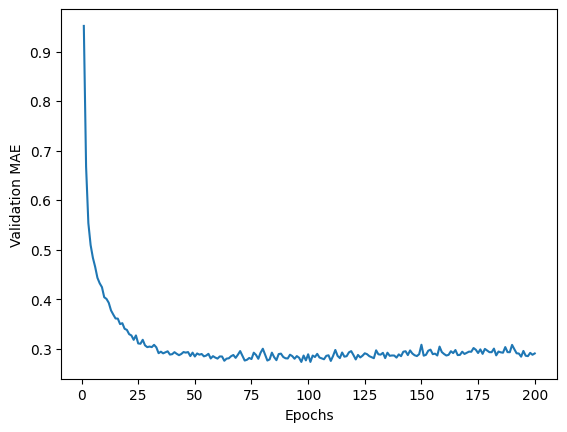

In [16]:
import matplotlib.pyplot as plt
epochs = range(1, len(average_mae_history) + 1)
plt.plot(epochs, average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to read the plot due to a scaling issue: the validation MAE for the first few epochs is dramatically higher than the values that follow. Let’s omit the first 10 data points, which are on a different scale than the rest of the curve.

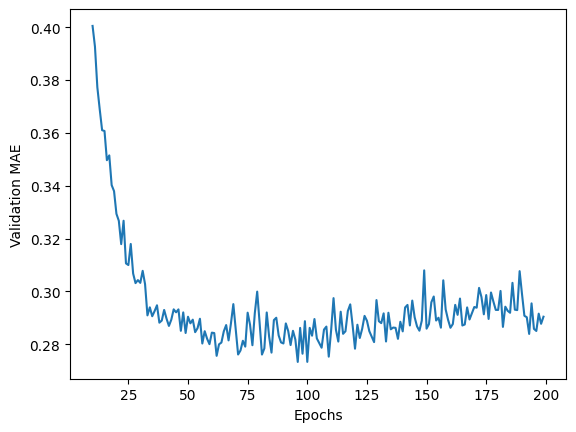

In [17]:
truncated_mae_history = average_mae_history[10:]
epochs = range(10, len(truncated_mae_history) + 10)
plt.plot(epochs, truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

### Determining When to Stop Training — Summary

From the validation MAE plot, performance **stops improving after about 120–140 epochs**.  
Training beyond this point leads to **overfitting**, where the model fits the training data too closely and generalizes poorly.

After selecting the best number of epochs (and possibly tuning layer sizes or other parameters), you then:

1. **Train a final model** using **all available training data** and the optimized settings.  
2. **Evaluate this final model on the test set** to measure how well it performs on unseen data.


In [18]:
# Gets a fresh, compiled model
model = get_model()
# Trains it on the entirety of the data
model.fit(x_train, y_train, epochs=130, batch_size=16, verbose=0)
test_mean_squared_error, test_mean_absolute_error = model.evaluate(
    x_test, y_test
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3170 - mean_absolute_error: 0.3403


In [19]:
round(test_mean_absolute_error, 3)

0.323

We’re still off by about $31,000 on average.

### Generating Predictions — Summary

- For **binary classification**, `predict()` returns a **scalar score** between 0 and 1.  
- For **multiclass classification**, `predict()` returns a **probability distribution** over classes.  
- For **scalar regression** (like predicting house prices), `predict()` returns the model’s **estimated price** in **hundreds of thousands of dollars** for each input sample.

The first district in the test set is predicted to have an average home price of about $283,000.